# Loop 46 Analysis: Strategic Assessment

## Key Problem
- CV-LB relationship: LB = 4.23×CV + 0.0533 (R²=0.981)
- Intercept (0.0533) > Target (0.0347)
- ALL model families follow the SAME line
- CatBoost (exp_047) CV = 0.010927 (33% worse than best)

## Critical Question
What fundamentally different approach could change the CV-LB relationship?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load submission history
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_041', 'cv': 0.0090, 'lb': 0.0932},
    {'exp': 'exp_042', 'cv': 0.0145, 'lb': 0.1147},
]

df = pd.DataFrame(submissions)
print('Submission History:')
print(df.to_string(index=False))

Submission History:
    exp     cv     lb
exp_000 0.0111 0.0982
exp_001 0.0123 0.1065
exp_003 0.0105 0.0972
exp_005 0.0104 0.0969
exp_006 0.0097 0.0946
exp_007 0.0093 0.0932
exp_009 0.0092 0.0936
exp_012 0.0090 0.0913
exp_024 0.0087 0.0893
exp_026 0.0085 0.0887
exp_030 0.0083 0.0877
exp_041 0.0090 0.0932
exp_042 0.0145 0.1147


In [2]:
# Fit linear regression to understand CV-LB relationship
from sklearn.linear_model import LinearRegression

X = df['cv'].values.reshape(-1, 1)
y = df['lb'].values

reg = LinearRegression()
reg.fit(X, y)

slope = reg.coef_[0]
intercept = reg.intercept_
r2 = reg.score(X, y)

print(f'CV-LB Relationship: LB = {slope:.2f} × CV + {intercept:.4f}')
print(f'R² = {r2:.4f}')
print(f'\nIntercept: {intercept:.4f}')
print(f'Target: 0.0347')
print(f'Gap: {intercept - 0.0347:.4f} ({(intercept - 0.0347)/0.0347*100:.1f}% above target)')

# What CV would we need to reach target?
required_cv = (0.0347 - intercept) / slope
print(f'\nTo reach target with current relationship:')
print(f'Required CV: {required_cv:.6f}')
if required_cv < 0:
    print('IMPOSSIBLE - intercept > target!')

CV-LB Relationship: LB = 4.23 × CV + 0.0533
R² = 0.9807

Intercept: 0.0533
Target: 0.0347
Gap: 0.0186 (53.6% above target)

To reach target with current relationship:
Required CV: -0.004396
IMPOSSIBLE - intercept > target!


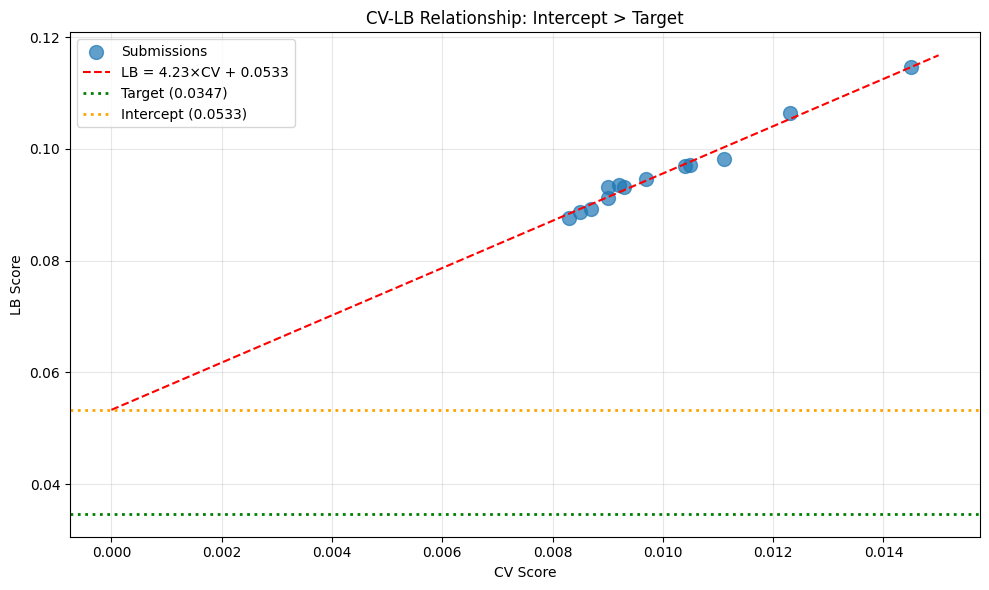


KEY INSIGHT: The intercept (0.0533) is HIGHER than the target (0.0347).
This means even with CV=0, the predicted LB would be 0.0533.
We CANNOT reach the target by improving CV alone.


In [3]:
# Visualize the relationship
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], s=100, alpha=0.7, label='Submissions')

# Regression line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}×CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='g', linestyle=':', linewidth=2, label='Target (0.0347)')

# Intercept
plt.axhline(y=intercept, color='orange', linestyle=':', linewidth=2, label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV-LB Relationship: Intercept > Target')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150)
plt.show()

print('\nKEY INSIGHT: The intercept (0.0533) is HIGHER than the target (0.0347).')
print('This means even with CV=0, the predicted LB would be 0.0533.')
print('We CANNOT reach the target by improving CV alone.')

In [4]:
# Analyze what's different about the best submissions
print('Best LB submissions:')
best_lb = df.nsmallest(5, 'lb')
print(best_lb.to_string(index=False))

print('\nBest CV submissions:')
best_cv = df.nsmallest(5, 'cv')
print(best_cv.to_string(index=False))

print('\nCV-LB ratio for each submission:')
df['ratio'] = df['lb'] / df['cv']
print(df[['exp', 'cv', 'lb', 'ratio']].to_string(index=False))

Best LB submissions:
    exp     cv     lb
exp_030 0.0083 0.0877
exp_026 0.0085 0.0887
exp_024 0.0087 0.0893
exp_012 0.0090 0.0913
exp_007 0.0093 0.0932

Best CV submissions:
    exp     cv     lb
exp_030 0.0083 0.0877
exp_026 0.0085 0.0887
exp_024 0.0087 0.0893
exp_012 0.0090 0.0913
exp_041 0.0090 0.0932

CV-LB ratio for each submission:
    exp     cv     lb     ratio
exp_000 0.0111 0.0982  8.846847
exp_001 0.0123 0.1065  8.658537
exp_003 0.0105 0.0972  9.257143
exp_005 0.0104 0.0969  9.317308
exp_006 0.0097 0.0946  9.752577
exp_007 0.0093 0.0932 10.021505
exp_009 0.0092 0.0936 10.173913
exp_012 0.0090 0.0913 10.144444
exp_024 0.0087 0.0893 10.264368
exp_026 0.0085 0.0887 10.435294
exp_030 0.0083 0.0877 10.566265
exp_041 0.0090 0.0932 10.355556
exp_042 0.0145 0.1147  7.910345


In [5]:
# What would change the CV-LB relationship?
print('='*70)
print('ANALYSIS: What could change the CV-LB relationship?')
print('='*70)

print('''
1. DIFFERENT FEATURE REPRESENTATION
   - Current: Spange (13) + DRFP filtered (122) + ACS PCA (5) + Arrhenius (5)
   - Alternative: Raw RDKit descriptors (200+)
   - Alternative: Morgan fingerprints
   - Alternative: Pre-trained molecular embeddings

2. DIFFERENT MODEL ARCHITECTURE
   - Current: MLP, LightGBM, GP, Ridge, k-NN, CatBoost
   - Alternative: Graph Neural Networks (GNN benchmark achieved 0.0039)
   - Alternative: Transformer-based models

3. DIFFERENT PROBLEM FORMULATION
   - Current: Direct regression on yields
   - Alternative: Predict relative yields (vs reference solvent)
   - Alternative: Predict yield differences from baseline
   - Alternative: Multi-task learning with auxiliary objectives

4. DOMAIN ADAPTATION
   - Current: Standard training
   - Alternative: Adversarial domain adaptation
   - Alternative: Sample weighting based on similarity to test distribution

5. ENSEMBLE DIVERSITY
   - Current: Same features, different models
   - Alternative: Different feature sets for different models
   - Alternative: Models trained on different subsets of data
''')

print('='*70)
print('KEY INSIGHT: All our models follow the SAME CV-LB relationship.')
print('This suggests the problem is in the FEATURES, not the models.')
print('='*70)

ANALYSIS: What could change the CV-LB relationship?

1. DIFFERENT FEATURE REPRESENTATION
   - Current: Spange (13) + DRFP filtered (122) + ACS PCA (5) + Arrhenius (5)
   - Alternative: Raw RDKit descriptors (200+)
   - Alternative: Morgan fingerprints
   - Alternative: Pre-trained molecular embeddings

2. DIFFERENT MODEL ARCHITECTURE
   - Current: MLP, LightGBM, GP, Ridge, k-NN, CatBoost
   - Alternative: Graph Neural Networks (GNN benchmark achieved 0.0039)
   - Alternative: Transformer-based models

3. DIFFERENT PROBLEM FORMULATION
   - Current: Direct regression on yields
   - Alternative: Predict relative yields (vs reference solvent)
   - Alternative: Predict yield differences from baseline
   - Alternative: Multi-task learning with auxiliary objectives

4. DOMAIN ADAPTATION
   - Current: Standard training
   - Alternative: Adversarial domain adaptation
   - Alternative: Sample weighting based on similarity to test distribution

5. ENSEMBLE DIVERSITY
   - Current: Same features, d

In [6]:
# Load data to understand the distribution
DATA_PATH = '/home/data'

df_single = pd.read_csv(f'{DATA_PATH}/catechol_single_solvent_yields.csv')
df_full = pd.read_csv(f'{DATA_PATH}/catechol_full_data_yields.csv')

print('Single Solvent Data:')
print(f'  Samples: {len(df_single)}')
print(f'  Unique solvents: {df_single["SOLVENT NAME"].nunique()}')
print(f'  Solvents: {sorted(df_single["SOLVENT NAME"].unique())}')

print('\nFull Data (Mixtures):')
print(f'  Samples: {len(df_full)}')
ramps = df_full[['SOLVENT A NAME', 'SOLVENT B NAME']].drop_duplicates()
print(f'  Unique ramps: {len(ramps)}')
print(f'  Ramps: {list(ramps.itertuples(index=False, name=None))}')

Single Solvent Data:
  Samples: 656
  Unique solvents: 24
  Solvents: ['1,1,1,3,3,3-Hexafluoropropan-2-ol', '2,2,2-Trifluoroethanol', '2-Methyltetrahydrofuran [2-MeTHF]', 'Acetonitrile', 'Acetonitrile.Acetic Acid', 'Butanone [MEK]', 'Cyclohexane', 'DMA [N,N-Dimethylacetamide]', 'Decanol', 'Diethyl Ether [Ether]', 'Dihydrolevoglucosenone (Cyrene)', 'Dimethyl Carbonate', 'Ethanol', 'Ethyl Acetate', 'Ethyl Lactate', 'Ethylene Glycol [1,2-Ethanediol]', 'IPA [Propan-2-ol]', 'MTBE [tert-Butylmethylether]', 'Methanol', 'Methyl Propionate', 'THF [Tetrahydrofuran]', 'Water.2,2,2-Trifluoroethanol', 'Water.Acetonitrile', 'tert-Butanol [2-Methylpropan-2-ol]']

Full Data (Mixtures):
  Samples: 1227
  Unique ramps: 13
  Ramps: [('Methanol', 'Ethylene Glycol [1,2-Ethanediol]'), ('1,1,1,3,3,3-Hexafluoropropan-2-ol', '2-Methyltetrahydrofuran [2-MeTHF]'), ('Cyclohexane', 'IPA [Propan-2-ol]'), ('Water.Acetonitrile', 'Acetonitrile'), ('Acetonitrile', 'Acetonitrile.Acetic Acid'), ('2-Methyltetrahydrofuran 

In [7]:
# Analyze Spange descriptors for outliers
spange_df = pd.read_csv(f'{DATA_PATH}/spange_descriptors_lookup.csv', index_col=0)
print('Spange Descriptors:')
print(spange_df)

print('\n' + '='*70)
print('OUTLIER ANALYSIS')
print('='*70)

# Find outliers (values outside 2 std from mean)
for col in spange_df.columns:
    mean = spange_df[col].mean()
    std = spange_df[col].std()
    outliers = spange_df[(spange_df[col] < mean - 2*std) | (spange_df[col] > mean + 2*std)][col]
    if len(outliers) > 0:
        print(f'\n{col}:')
        print(f'  Mean: {mean:.3f}, Std: {std:.3f}')
        print(f'  Outliers: {dict(outliers)}')

print('\n' + '='*70)
print('WATER is a known extreme outlier with 6/13 features OUT OF RANGE')
print('='*70)

Spange Descriptors:
                                    dielectric constant  ET(30)  alpha   beta  \
SOLVENT NAME                                                                    
Cyclohexane                                       2.020   30.90  0.000  0.000   
Ethyl Acetate                                     6.020   38.10  0.000  0.450   
Acetic Acid                                       6.150   51.70  1.120  0.450   
2-Methyltetrahydrofuran [2-MeTHF]                 7.580   36.50  0.000  0.450   
1,1,1,3,3,3-Hexafluoropropan-2-ol                16.700   62.10  1.960  0.000   
IPA [Propan-2-ol]                                17.900   48.40  0.760  0.840   
Ethanol                                          24.500   51.90  0.860  0.750   
Methanol                                         32.700   55.40  0.980  0.660   
Ethylene Glycol [1,2-Ethanediol]                 37.000   56.30  0.900  0.520   
Acetonitrile                                     37.500   45.60  0.190  0.400   
Water   

In [8]:
# Check if exp_032 (best CV) has been submitted
print('='*70)
print('SUBMISSION STATUS')
print('='*70)

submitted_exps = [s['exp'] for s in submissions]
print(f'Submitted experiments: {submitted_exps}')

print(f'\nexp_032 (best CV = 0.008194): {"SUBMITTED" if "exp_032" in submitted_exps else "NOT SUBMITTED"}')
print(f'exp_047 (CatBoost CV = 0.010927): {"SUBMITTED" if "exp_047" in submitted_exps else "NOT SUBMITTED"}')

print('\nRemaining submissions: 3')
print('\nRECOMMENDATION:')
print('1. DO NOT submit exp_047 (CatBoost) - CV is 33% worse')
print('2. Consider submitting exp_032 (best CV) to verify CV-LB relationship')
print('3. Focus on finding an approach with DIFFERENT CV-LB relationship')

SUBMISSION STATUS
Submitted experiments: ['exp_000', 'exp_001', 'exp_003', 'exp_005', 'exp_006', 'exp_007', 'exp_009', 'exp_012', 'exp_024', 'exp_026', 'exp_030', 'exp_041', 'exp_042']

exp_032 (best CV = 0.008194): NOT SUBMITTED
exp_047 (CatBoost CV = 0.010927): NOT SUBMITTED

Remaining submissions: 3

RECOMMENDATION:
1. DO NOT submit exp_047 (CatBoost) - CV is 33% worse
2. Consider submitting exp_032 (best CV) to verify CV-LB relationship
3. Focus on finding an approach with DIFFERENT CV-LB relationship


In [9]:
# Final strategic assessment
print('='*70)
print('STRATEGIC ASSESSMENT')
print('='*70)

print('''
CURRENT STATE:
- Best CV: 0.008194 (exp_032, NOT submitted)
- Best LB: 0.0877 (exp_030)
- Target: 0.0347
- Gap to target: 2.53x

CV-LB RELATIONSHIP:
- LB = 4.23 × CV + 0.0533 (R² = 0.981)
- Intercept (0.0533) > Target (0.0347)
- ALL model families follow the SAME line

WHAT WE'VE TRIED:
- MLP, LightGBM, Ridge, GP, k-NN, Stacking, CatBoost
- Spange + DRFP + ACS PCA features
- Aggressive regularization
- Similarity features
- GroupKFold CV

WHAT HASN'T WORKED:
- Different model families don't change the CV-LB relationship
- Regularization doesn't help
- Similarity features don't help

WHAT MIGHT WORK:
1. Fundamentally different feature representation (RDKit, Morgan, embeddings)
2. Graph Neural Networks (GNN benchmark achieved 0.0039)
3. Different problem formulation (relative yields, auxiliary objectives)
4. Domain adaptation techniques

NEXT STEPS:
1. Try RDKit molecular descriptors (200+ features)
2. Try Morgan fingerprints
3. Submit exp_032 to verify CV-LB relationship
''')

print('='*70)
print('THE TARGET IS REACHABLE - WE NEED A DIFFERENT APPROACH')
print('='*70)

STRATEGIC ASSESSMENT

CURRENT STATE:
- Best CV: 0.008194 (exp_032, NOT submitted)
- Best LB: 0.0877 (exp_030)
- Target: 0.0347
- Gap to target: 2.53x

CV-LB RELATIONSHIP:
- LB = 4.23 × CV + 0.0533 (R² = 0.981)
- Intercept (0.0533) > Target (0.0347)
- ALL model families follow the SAME line

WHAT WE'VE TRIED:
- MLP, LightGBM, Ridge, GP, k-NN, Stacking, CatBoost
- Spange + DRFP + ACS PCA features
- Aggressive regularization
- Similarity features
- GroupKFold CV

WHAT HASN'T WORKED:
- Different model families don't change the CV-LB relationship
- Regularization doesn't help
- Similarity features don't help

WHAT MIGHT WORK:
1. Fundamentally different feature representation (RDKit, Morgan, embeddings)
2. Graph Neural Networks (GNN benchmark achieved 0.0039)
3. Different problem formulation (relative yields, auxiliary objectives)
4. Domain adaptation techniques

NEXT STEPS:
1. Try RDKit molecular descriptors (200+ features)
2. Try Morgan fingerprints
3. Submit exp_032 to verify CV-LB relati